# Time delay-cosmography with uncertain PSF

This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/lenstronomy/lenstronomy)
- STARRED (https://gitlab.com/cosmograil/starred), based on the method described in https://ui.adsabs.harvard.edu/abs/2024arXiv240208725M/abstract


This notebook is an extension of [this notebook](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/TimeDelayCosmography/time_delay_cosmography_with_uncertain_psf.ipynb), using STARRED instead of the lenstronomy build-in PSF iteration procedure. 
STARRED offers two main advantages: 


- it leverages the sub-pixel PSF information contained in the 4 quasar images, that are projected with different sub-pixel shift on the pixel grid. In other word, STARRED is reconstructing a drizzled version of the PSF, which allows us to reconstruct features of the PSF that are not sampled at the original pixel scale. For this reason, __we highly recommend to use__ `point_source_supersampling_factor = 3`. Choosing a even `point_source_supersampling_factor` will result in some inconsistency between the STARRED and lenstronomy PSF centering convention.


- STARRED uses a sparse regularisation procedure, that has also the effect of denoising the reconstructed PSF. You can choose the "intensity" of the denoising by changing 'lambda_scales' and 'lambda_hf'. 'lambda_scales = lambda_hf = 3' means that only the feature that are 3$\sigma$ above the noise level will be reconstructed in the PSF. __We recommend to use__ '2 < lambda_scales = lambda_hf < 3' for optimal reconstruction.

Note that STARRED runs perfectly fine on CPU but it is much faster on GPU. You'll need a GPU compatible JAX installation for that. See the [STARRED documentation](https://cosmograil.gitlab.io/starred/installation.html) for more detail.

The key parameters to adjust the behavior of STARRED are passed through 'kwargs_psf_iter`. Here is a minimal example:

```
kwargs_psf_iter = { 
                'keep_psf_error_map': True, 
                'num_iter': 1, #we will just run STARRED once, you might want to run it more than once (3 is a good number for a first reconstruction)
                'psf_iter_factor': 1, # we will fully update the PSF (recommended)
                'kwargs_starred': {'verbose':True, 'lambda_scales':3, 'lambda_hf':3}, #Choose regularisation parameters here
                'use_starred': True, 
                } 
```
Other options can be passed to control the behavior of the optimiser. Keyword arguments contained in `kwargs_starred` are passed to this [STARRED function](https://gitlab.com/cosmograil/starred/-/blob/main/starred/procedures/psf_routines.py?ref_type=heads#L225).

Finally, If you make use of the STARRED PSF fitting algorithm, we recommend acknowledging the papers listed [here](https://cosmograil.gitlab.io/starred/citing.html). 

For further information, please get in touch with the author of this notebook, Simon Birrer: sibirrer@gmail.com and Martin Millon: martin.millon@hotmail.fr for the STARRED part

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    %pip install lenstronomy

try:
    import starred
except:
    %pip install starred-astro

# lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import dill as pkl

DEPRECATION: Loading egg at /home/charlie/Documents/Wolfram/lib/python3.12/site-packages/UNKNOWN-0.0.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 11.3 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 MB 13.8 MB/s eta 0:00:00m eta 0:00:010:0102
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 17.7 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## simulation choices

/tmp/ipykernel_218841/2869137786.py:18: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  kernel_blurred = ndimage.filters.gaussian_filter(kernel, 0.5, mode='nearest', truncate=5)


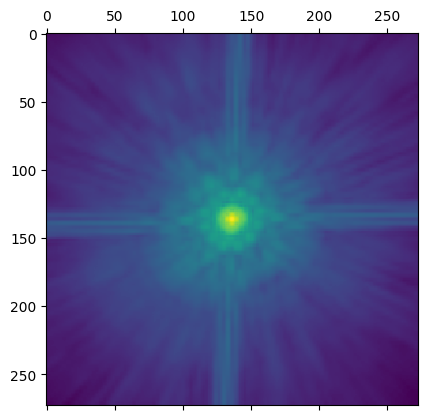

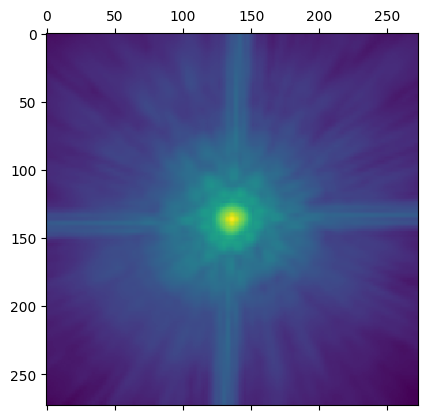

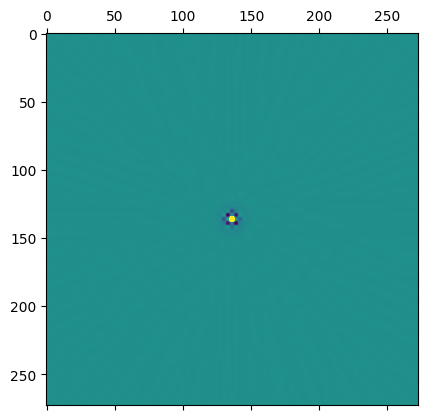

In [2]:

# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
point_source_supersampling_factor = 3
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


# import PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Data/PSF_TinyTim/psf_example.fits')
kernel = pyfits.getdata(psf_filename)

# blurr the PSF, this will be our starting point estimate
import scipy.ndimage as ndimage
kernel_blurred = ndimage.filters.gaussian_filter(kernel, 0.5, mode='nearest', truncate=5)
    
# data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.05#  pixel size in arcsec (area per pixel = deltaPix**2)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)
# generate the psf variables
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)

# we will provide a subsampled version of the PSF kernel to the PSF class, this is required as STARRED works much better with a subsampled PSF.
# This has to be set at the initialisation of the PSF class, the psf_iteration routines can not update that during the fit at the momment. 
if point_source_supersampling_factor > 1:
    kernel_cut = kernel_util.subgrid_kernel(kernel_cut, subgrid_res=point_source_supersampling_factor, odd=True, num_iter=100)

kwargs_psf_true = {'psf_type': psf_type, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut,
                   'point_source_supersampling_factor': point_source_supersampling_factor}

kernel_cut_blurred = kernel_util.cut_psf(kernel_blurred, kernel_size)
if point_source_supersampling_factor > 1:
    kernel_cut_blurred = kernel_util.subgrid_kernel(kernel_cut_blurred, subgrid_res=point_source_supersampling_factor, odd=True, num_iter=100)

kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut_blurred, 
              'point_source_supersampling_factor': point_source_supersampling_factor}
psf_class_true = PSF(**kwargs_psf_true)
psf_class = PSF(**kwargs_psf)


plt.matshow(np.log10(kernel_cut))
plt.show()

plt.matshow(np.log10(kernel_cut_blurred))
plt.show()

plt.matshow(kernel_cut - kernel_cut_blurred, vmin=-0.001, vmax=0.001)
plt.show()


/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(
/tmp/ipykernel_218841/3022968953.py:78: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


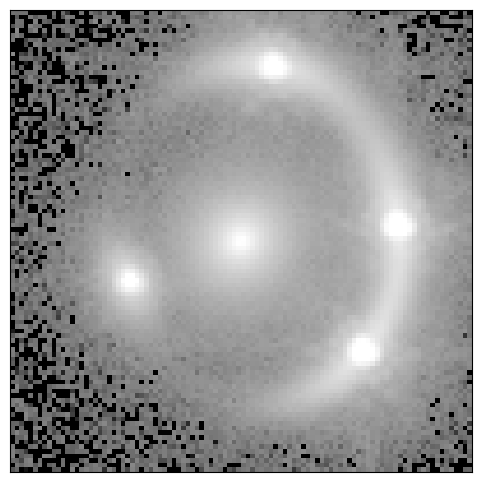

In [3]:
# lensing quantities
gamma1, gamma2 = param_util.shear_polar2cartesian(phi=-np.pi/2, gamma=0.05)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  # shear values
kwargs_pemd = {'theta_E': 1.66, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model

# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['EPL', 'SHEAR']
kwargs_lens = [kwargs_pemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

source_x = 0.2
source_y = 0.1


# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
phi_G, q = 0.9, 0.9
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*1000}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False,
                  'point_source_supersampling_factor': point_source_supersampling_factor}

imageModel = ImageModel(data_class, psf_class_true, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
image_sim = image_sim + bkg + poisson
data_class.update_data(image_sim)
kwargs_data['image_data'] = image_sim


kwargs_model = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

## time delays
time delays are defined in **lenstronomy** as the difference in light travel path relative to a straight line. Negative values correspond to earlier arrival times. The units are in days.

In [4]:
# time delays, the unit [days] is matched when the lensing angles are in arcsec

from lenstronomy.Analysis.td_cosmography import TDCosmography
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

# time delays, the unit [days] is matched when the lensing angles are in arcsec
t_days = td_cosmo.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
print("the time delays for the images at position ", kwargs_ps[0]['ra_image'], kwargs_ps[0]['dec_image'], "are: ", t_days)

# relative delays (observable). The convention is relative to the first image
dt_days =  t_days[1:] - t_days[0]
# and errors can be assigned to the measured relative delays (full covariance matrix not yet implemented)
dt_sigma = [3, 5, 2]  # Gaussian errors
# and here a realisation of the measurement with the quoted error bars
dt_measured = np.random.normal(dt_days, dt_sigma)
print("the measured relative delays are: ", dt_measured)

the time delays for the images at position  [ 0.35302851  1.32507501  1.69993942 -1.1973414 ] [ 1.8915277  -1.19417343  0.16522287 -0.43528866] are:  [-147.69894773 -133.21139497 -128.32128449  -67.49330428]
the measured relative delays are:  [16.04603852 22.85859838 76.26874013]


## Model and parameter choices

In [5]:
# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 1.5, 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'e1': 0, 'e2': 0.})
#kwargs_lens_init.append(kwargs_spemd)
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'q': .5, 'gamma': 1.5, 'phi_G': 0., 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10,'q': .5, 'gamma': 2.5, 'phi_G': 0., 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0, 'gamma2': 0})
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.5, 'gamma2': -0.5})
kwargs_upper_lens.append({'gamma1': 0.5, 'gamma2': 0.5})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
#kwargs_lens_light_init.append(kwargs_sersic_lens)
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
#kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(x_image)), 'dec_image': 0.01 * np.ones(len(x_image))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(x_image)), 'dec_image': -10 * np.ones(len(y_image))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(x_image)), 'dec_image': 10 * np.ones(len(y_image))}]

fixed_cosmo = {}
kwargs_cosmo_init = {'D_dt': 5000}
kwargs_cosmo_sigma = {'D_dt': 10000}
kwargs_lower_cosmo = {'D_dt': 0}
kwargs_upper_cosmo = {'D_dt': 10000}
cosmo_params = [kwargs_cosmo_init, kwargs_cosmo_sigma, fixed_cosmo, kwargs_lower_cosmo, kwargs_upper_cosmo]

ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'special': cosmo_params}


/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/LensModel/Solver/solver4point.py:96: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x = scipy.optimize.fsolve(


Computing the PSO ...


  0%|                                                                      | 0/100 [00:00<?, ?it/s]/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/LensModel/Solver/solver4point.py:96: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  x = scipy.optimize.fsolve(
100%|████████████████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/it]
/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),


Max iteration reached! Stopping.
-4.371618710578947 reduced X^2 of best position
-21801.262509657205 log likelihood
9974 effective number of data points
[{'theta_E': np.float64(1.652732910222671), 'gamma': 2, 'e1': np.float64(0.07506896660169286), 'e2': np.float64(0.08766917939577983), 'center_x': np.float64(0.01763554229199345), 'center_y': np.float64(0.00939882273091521)}, {'gamma1': np.float64(-0.06577945383780506), 'gamma2': np.float64(-0.008946419094700515), 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': np.float64(0.10279614340991575), 'n_sersic': np.float64(0.8993687425840298), 'e1': np.float64(0.07839466645265533), 'e2': np.float64(0.11060513335913895), 'center_x': np.float64(0.21461194201745334), 'center_y': np.float64(0.10592135395556036)}] source result
[{'amp': 1, 'R_sersic': np.float64(0.1982331774721762), 'n_sersic': np.float64(2.1416143210218164), 'e1': np.float64(-0.02143115535154976), 'e2': np.float64(0.05326063272580125), 'center_x': np.float64(-0.0003235

/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:1218: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()
/tmp/ipykernel_218841/754792438.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f, axes = modelPlot.plot_main(); f.show()
/tmp/ipykernel_218841/754792438.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f, axes = modelPlot.plot_separate(); f.show()
/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:1168: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data - model),
/tmp/ipykernel_218841/754792438.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f, axes = modelPlot.plot_subtract_from_data_all(); f.show()


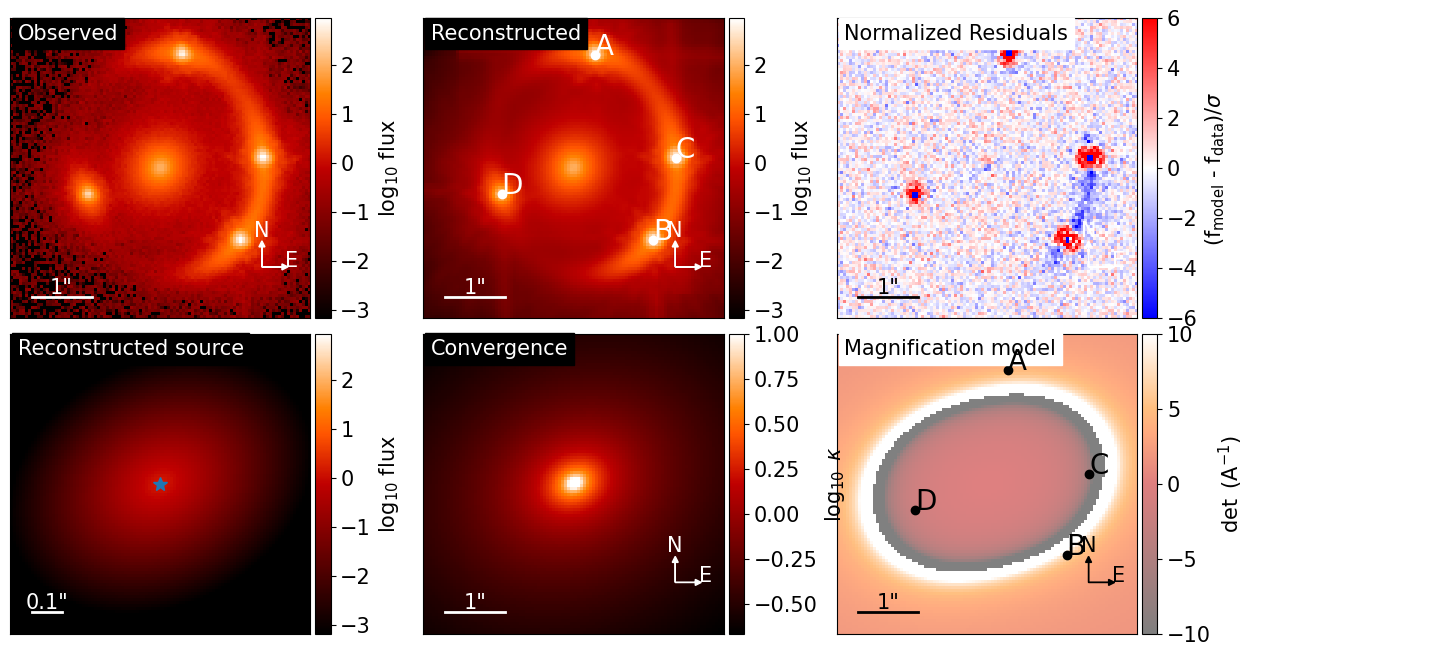

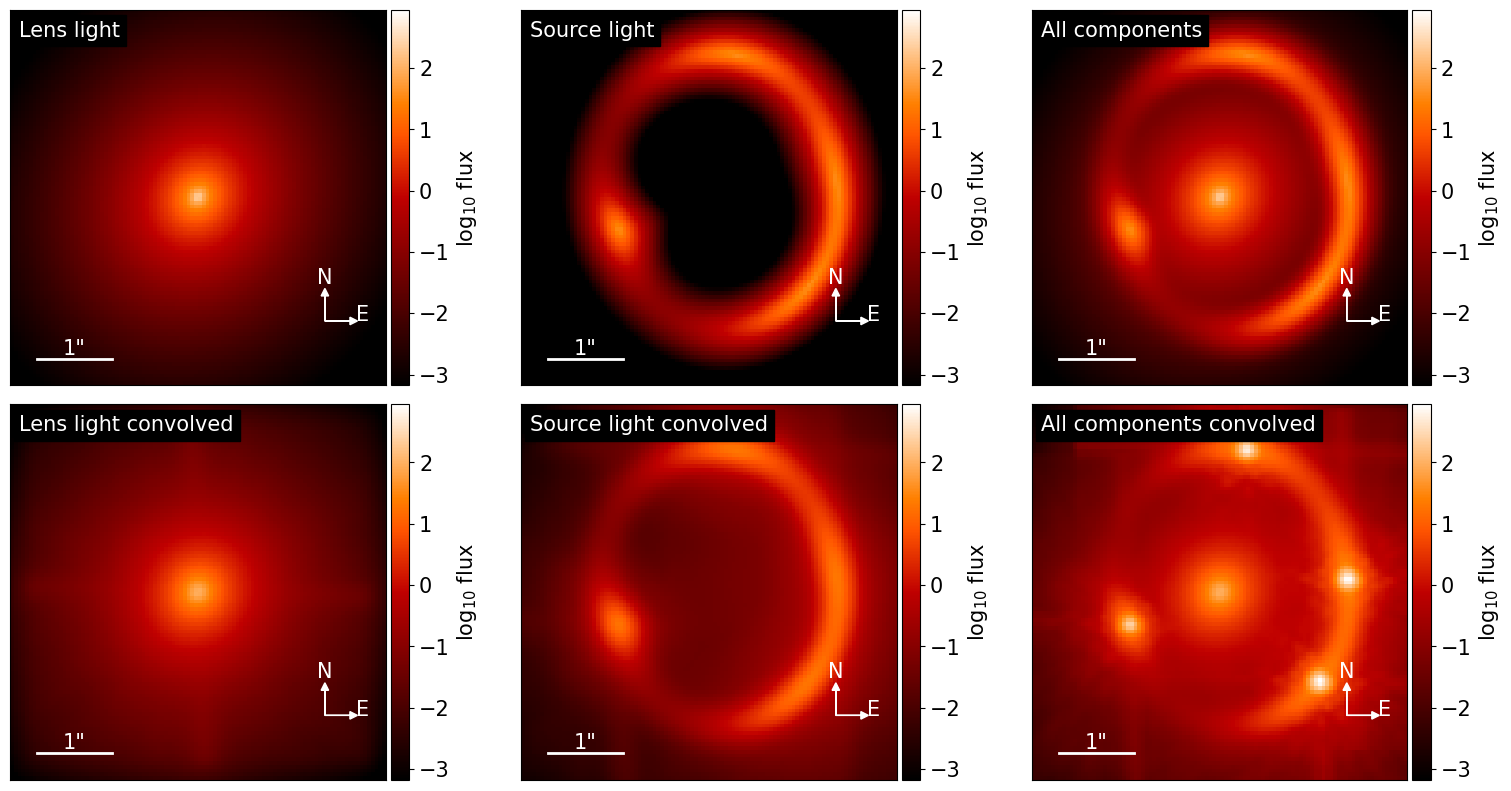

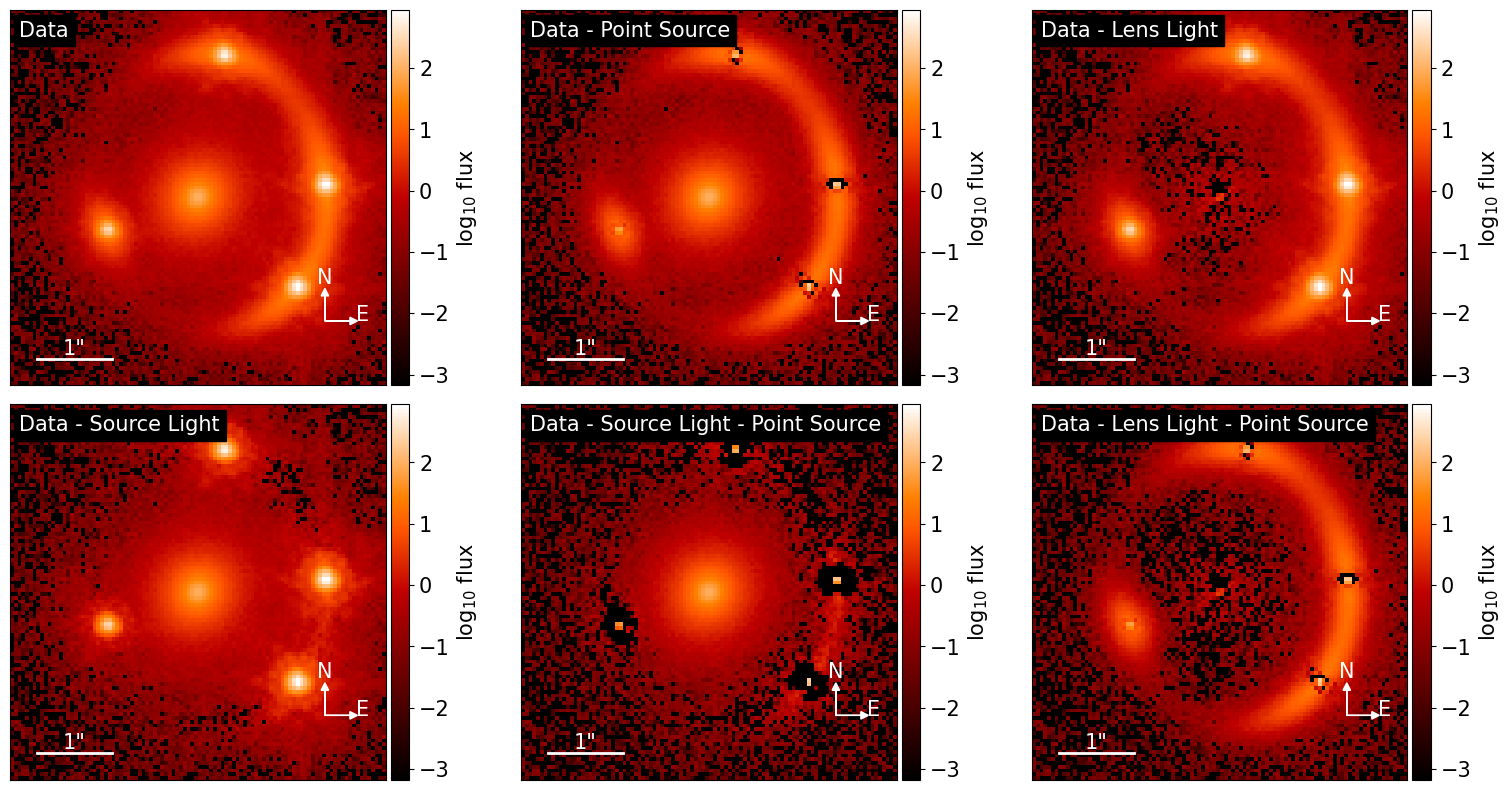

In [6]:
redo_fit = False

# now we first run a PSO with the wrong PSF
psf_iter_factor = 0.2
psf_iter_num = 100
sigma_scale = 0.1
# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                      'num_point_source_list': [4],
                      'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                      'Ddt_sampling': True,
                              }

kwargs_likelihood = {'check_bounds': True,
                             'force_no_add_image': False,
                             'source_marg': False,
                             'image_position_uncertainty': 0.004,
                             'source_position_likelihood': True,
                             'source_position_tolerance': 0.001,
                             'time_delay_likelihood': True,
                             }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear',
                    'time_delays_measured': dt_measured,
                    'time_delays_uncertainties': dt_sigma,}

kwargs_init = [kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps]

from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.
fitting_kwargs_list = [['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}],
                ['PSO', {'sigma_scale': sigma_scale, 'n_particles': 100, 'n_iterations': 100}],]

if not os.path.exists('./fitsequence.pkl') or redo_fit:
        from lenstronomy.Workflow.fitting_sequence import FittingSequence
        fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
        start_time = time.time()
        chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
        kwargs_result = fitting_seq.best_fit()
        end_time = time.time()
        print(end_time - start_time, 'total time needed for computation')
        print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')
        pkl.dump(fitting_seq, open('fitsequence.pkl', 'wb'))
        pkl.dump(chain_list, open('chainlist.pkl', 'wb'))

else:
        print('Loading from pickle file.')
        fitting_seq = pkl.load(open('fitsequence.pkl', 'rb'))
        chain_list = pkl.load(open('chainlist.pkl', 'rb'))
        kwargs_result = fitting_seq.best_fit()

# here is the output

from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main(); f.show()
f, axes = modelPlot.plot_separate(); f.show()
f, axes = modelPlot.plot_subtract_from_data_all(); f.show()

/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/Workflow/psf_fitting.py:404: UserWarning: Negative or zero values in the noise maps. Replacing these pixels with the median value.
  warnings.warn(


### Step 1, fixing : ['background'] ###


optax.adabelief: 100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 177.87it/s]
/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/starred/utils/noise_utils.py:53: RuntimeWarning: Mean of empty slice
  noise_map = np.nanmean(centered_masked_noise_maps, axis=0)


Step 1/2 took  3 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.7313886], dtype=float32), 'fwhm_y': Array([1.6329862], dtype=float32), 'phi': Array([-0.44179884], dtype=float32), 'beta': Array([2.0110314], dtype=float32), 'C': Array([0.93268186], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.3584416 , 2.048805  , 2.1124365 , 0.58981985], dtype=float32), 'x0': Array([-4.4046906e-01,  2.6211945e-05,  4.9292350e-01, -4.4823879e-01],      dtype=float32), 'y0': Array([ 0.34606662, -0.35532895, -0.18116279, -0.18862903], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  64422.28
Overall Reduced Chi2 :  3.8897645
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|███████████████████████████████████████████| 500/500 [00:14<00:00, 35.63it/s]


Step 2/2 took 15 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.7313886], dtype=float32), 'fwhm_y': Array([1.6329862], dtype=float32), 'phi': Array([-0.44179884], dtype=float32), 'beta': Array([2.0110314], dtype=float32), 'C': Array([0.93268186], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.1588387 , 1.8277413 , 1.8895437 , 0.48688042], dtype=float32), 'x0': Array([-0.4355759 ,  0.00929354,  0.49981925, -0.4432906 ], dtype=float32), 'y0': Array([ 0.32143098, -0.3757278 , -0.19338237, -0.20240903], dtype=float32)}, 'kwargs_background': {'background': Array([ 6.7642824e-05, -1.5705993e-04,  1.5635447e-06, ...,
       -5.2766945e-06,  7.1995280e-05, -4.4871766e-05], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  70199.28
Overall Reduced Chi2 :  2.238808


/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/Data/psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(


### Step 1, fixing : ['background'] ###


optax.adabelief: 100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 177.17it/s]


Step 1/2 took  3 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.5699049], dtype=float32), 'fwhm_y': Array([1.478426], dtype=float32), 'phi': Array([-0.43844187], dtype=float32), 'beta': Array([1.8517891], dtype=float32), 'C': Array([1.202771], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.579186  , 2.3727689 , 2.4528186 , 0.68082076], dtype=float32), 'x0': Array([-4.3767491e-01, -1.5031989e-04,  4.9221981e-01, -4.4696900e-01],      dtype=float32), 'y0': Array([ 0.33868504, -0.3549684 , -0.17979334, -0.18688795], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  42369.11
Overall Reduced Chi2 :  2.558212
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|███████████████████████████████████████████| 500/500 [00:14<00:00, 35.00it/s]


Step 2/2 took 15 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.5699049], dtype=float32), 'fwhm_y': Array([1.478426], dtype=float32), 'phi': Array([-0.43844187], dtype=float32), 'beta': Array([1.8517891], dtype=float32), 'C': Array([1.202771], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.3802307 , 2.157865  , 2.2355492 , 0.57373655], dtype=float32), 'x0': Array([-0.43994403,  0.00266175,  0.49395713, -0.4479988 ], dtype=float32), 'y0': Array([ 0.31973687, -0.3799766 , -0.19893694, -0.20715822], dtype=float32)}, 'kwargs_background': {'background': Array([-2.3667730e-04, -9.2999377e-05, -7.0703718e-05, ...,
        1.0729483e-05, -7.2592324e-05,  2.1374907e-04], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  50866.43
Overall Reduced Chi2 :  1.0697368
### Step 1, fixing : ['background'] ###


optax.adabelief: 100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 177.26it/s]


Step 1/2 took  3 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.5753527], dtype=float32), 'fwhm_y': Array([1.4857181], dtype=float32), 'phi': Array([-0.4361302], dtype=float32), 'beta': Array([1.8627731], dtype=float32), 'C': Array([0.9883729], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.5717412, 2.363481 , 2.443554 , 0.6782903], dtype=float32), 'x0': Array([-4.3829575e-01, -1.3703923e-04,  4.9162540e-01, -4.4676498e-01],      dtype=float32), 'y0': Array([ 0.33843014, -0.35508934, -0.17998642, -0.18703616], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  40424.01
Overall Reduced Chi2 :  2.4407687
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|███████████████████████████████████████████| 500/500 [00:14<00:00, 34.58it/s]


Step 2/2 took 15 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.5753527], dtype=float32), 'fwhm_y': Array([1.4857181], dtype=float32), 'phi': Array([-0.4361302], dtype=float32), 'beta': Array([1.8627731], dtype=float32), 'C': Array([0.9883729], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.3663287, 2.145936 , 2.2234597, 0.5527987], dtype=float32), 'x0': Array([-0.43269414,  0.0124275 ,  0.50194126, -0.44011894], dtype=float32), 'y0': Array([ 0.29389435, -0.40543324, -0.22410437, -0.23216313], dtype=float32)}, 'kwargs_background': {'background': Array([ 1.5072618e-04,  1.6169816e-04, -8.7799097e-05, ...,
        1.2015139e-05,  9.0328213e-05, -4.5185381e-05], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  43285.766
Overall Reduced Chi2 :  1.0297564
iteration of step 2 gave best reconstruction.
log likelihood before: -21800.3

/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/Plots/chain_plot.py:159: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(psf_out), origin="lower", **kwargs)
/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/Plots/chain_plot.py:200: RuntimeWarning: divide by zero encountered in log10
  np.log10(psf_variance_map * psf.kernel_point_source**2),
/tmp/ipykernel_218841/1310945241.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:67: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:224: RuntimeWarning: invalid value encountered in log10
  np.log10(self._model),
/tmp/ipykernel_218841/1310945241.py:41: UserWarning: FigureCanvasAgg is non-interactive, and

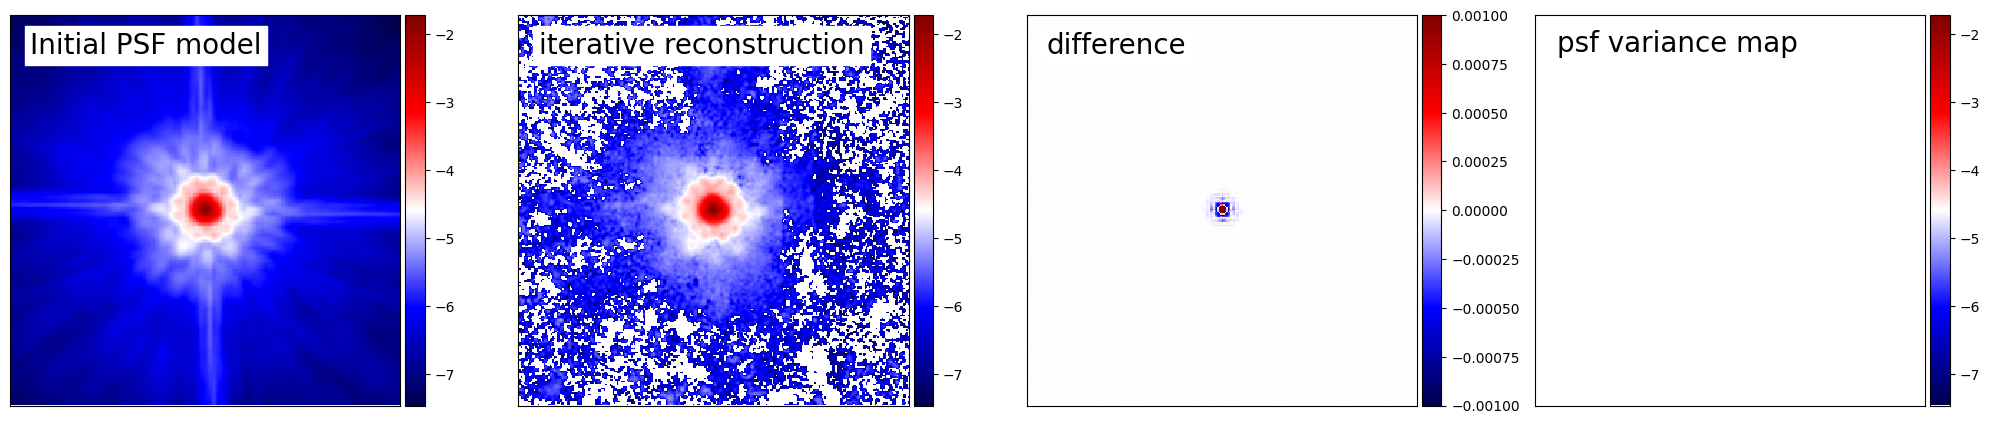

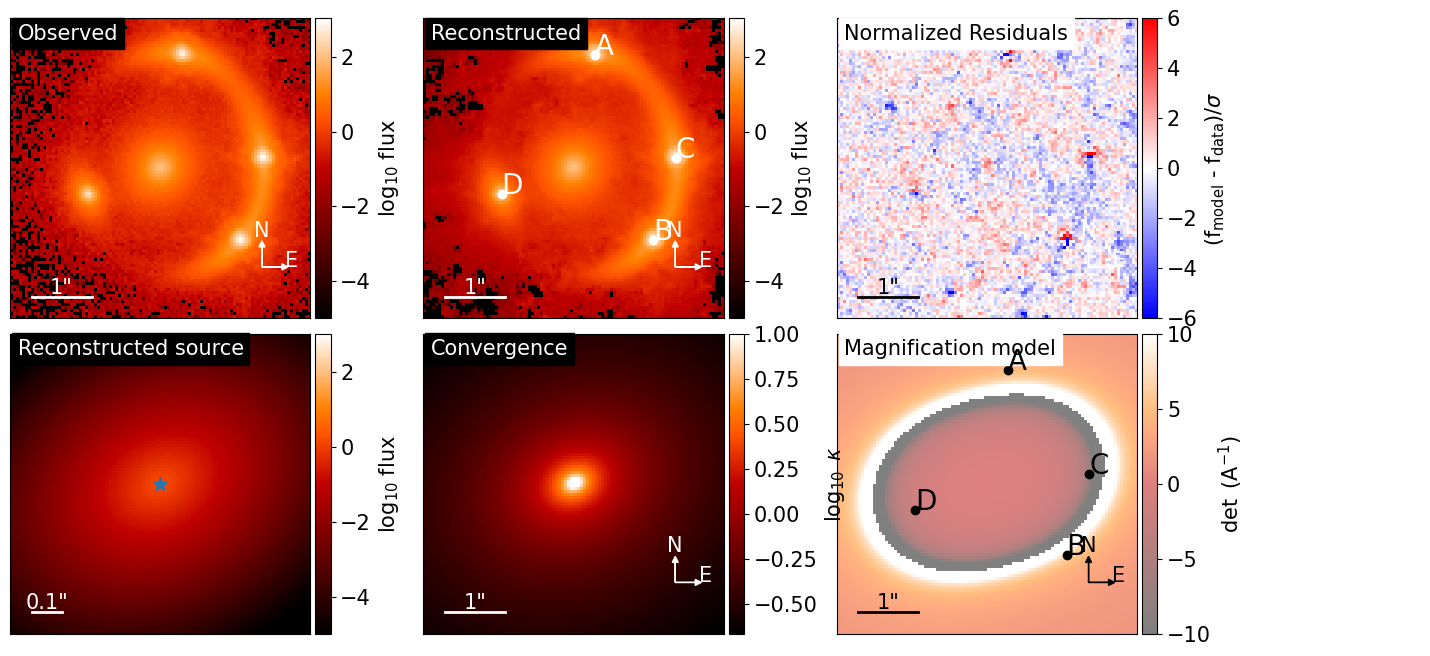

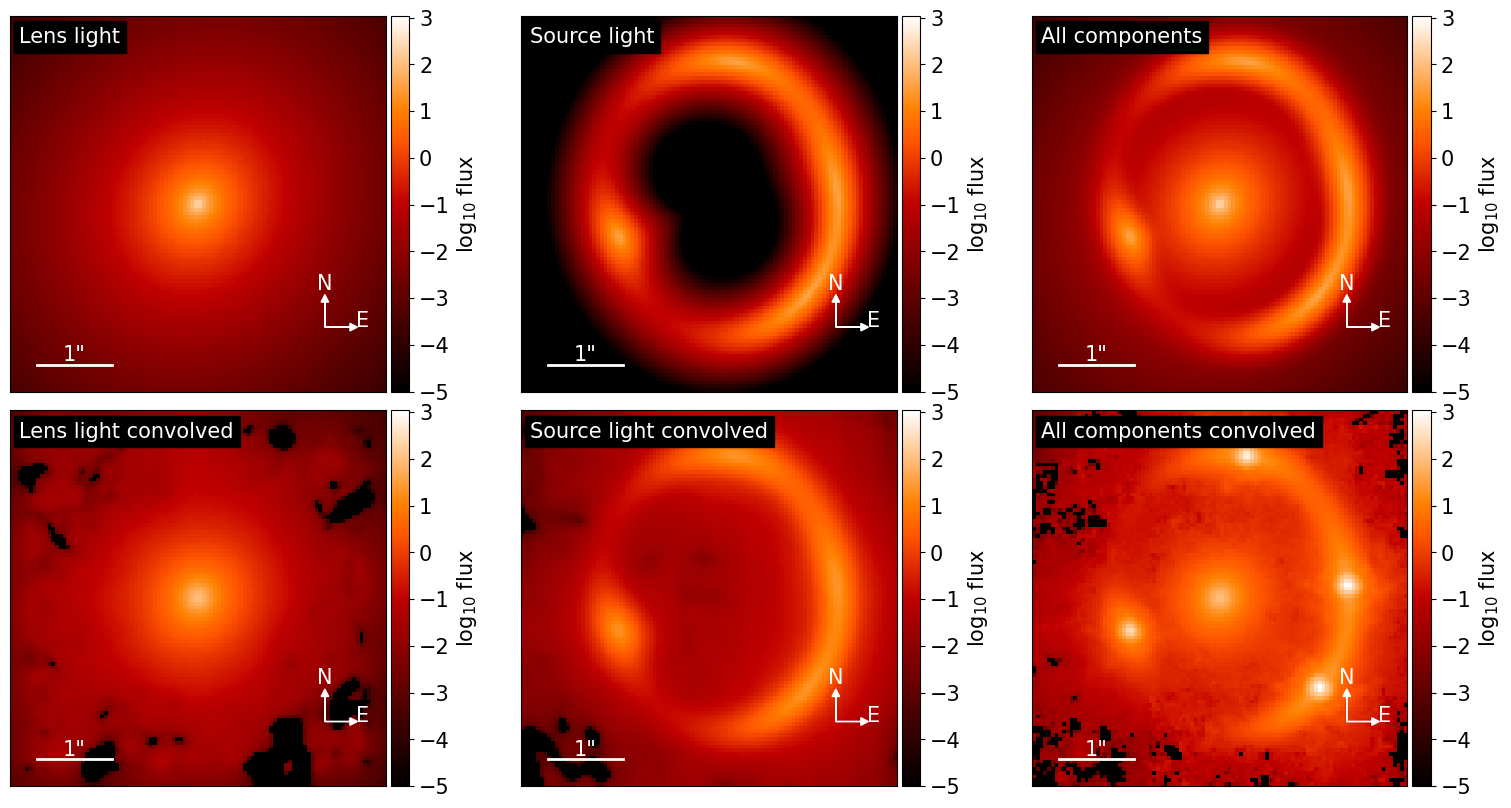

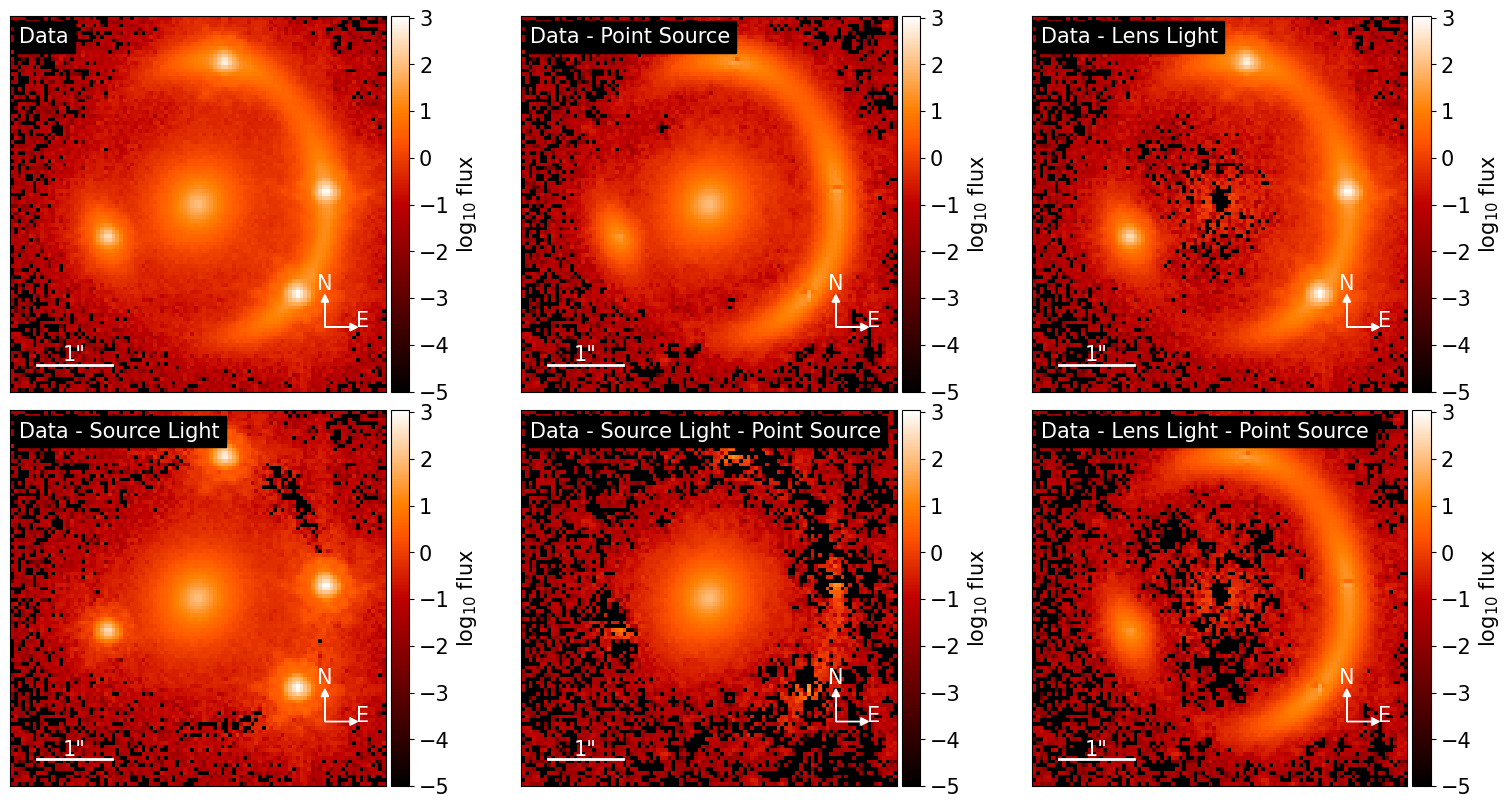

In [9]:
#now we run an iterative PSF reconstruction with the best fit model of the previous run
method_PSF_iteration = 'STARRED' #use 'STARRED' to use the STARRED method for PSF reconstruction or 'stack' to use the standard lenstronomy stacking method

kwargs_lbfgs = {'maxiter':1000}

kwargs_optax1 = {'max_iterations': 500, 'min_iterations': None,
                'init_learning_rate': 1e-2, 'schedule_learning_rate': True,
                'progress_bar': True} 

if method_PSF_iteration == 'STARRED':
    kwargs_psf_iter = { 
                    'keep_psf_variance_map': True, 
                    'psf_symmetry': 1, 
                    'block_center_neighbour': 0.05,
                    'num_iter': 3, #we run STARRED more than once, to see if the chi2 keeps improving after redoing the linear inversion with the new PSF. 
                    'psf_iter_factor': 1, #We fully update the PSF at each iteration, if the fit improves
                    'kwargs_starred': {'verbose':True, 'lambda_scales':3, 'lambda_hf':3, #Choose regularisation parameters, lambda_scales and lambda_hf should be 2 or 3 if the noise is correctly scaled 
                                       'optim_list':['adabelief', 'adabelief'], 'kwargs_optim_list':[kwargs_optax1, kwargs_optax1],#Choose the optimisers to use, and pass the kwargs accordingly. One for the Moffat fit, one for the full PSF fit. 
                                       }, 
                    'use_starred': True, 
                    } 

else: 
    kwargs_psf_iter = {'stacking_method': 'median', 
                    'keep_psf_variance_map': True, 
                    'psf_symmetry': 2, 
                    'block_center_neighbour': 0.05,
                    'num_iter': psf_iter_num, 
                    'psf_iter_factor': psf_iter_factor}

fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
#lens_result, source_result, lens_light_result, ps_result, cosmo_result

multi_band_list = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]
f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()



Computing the PSO ...


100%|████████████████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/it]


Max iteration reached! Stopping.
-1.308586062077385 reduced X^2 of best position
-6525.26439854888 log likelihood
9973 effective number of data points
[{'theta_E': np.float64(1.6539658534554622), 'gamma': np.float64(2.0092981601249758), 'e1': np.float64(0.08390665435291454), 'e2': np.float64(0.09243220216414325), 'center_x': np.float64(0.013420659470073985), 'center_y': np.float64(0.006448230354440613)}, {'gamma1': np.float64(-0.06410458473440944), 'gamma2': np.float64(-0.008308699086526448), 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': np.float64(0.10341928386089914), 'n_sersic': np.float64(0.9633460672557076), 'e1': np.float64(0.076290088764484), 'e2': np.float64(0.1038633625023679), 'center_x': np.float64(0.21601084153593383), 'center_y': np.float64(0.10649494713802236)}] source result
[{'amp': 1, 'R_sersic': np.float64(0.20101188902466502), 'n_sersic': np.float64(2.048123799614521), 'e1': np.float64(-0.01334931134585732), 'e2': np.float64(0.05416999466363572), 'cente

optax.adabelief: 100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 184.80it/s]


Step 1/2 took  3 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.5794846], dtype=float32), 'fwhm_y': Array([1.4857891], dtype=float32), 'phi': Array([-0.43593848], dtype=float32), 'beta': Array([1.8754499], dtype=float32), 'C': Array([1.1819208], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.5690271, 2.3577814, 2.4414058, 0.6790364], dtype=float32), 'x0': Array([-4.3807173e-01, -4.8643845e-04,  4.9189129e-01, -4.4673041e-01],      dtype=float32), 'y0': Array([ 0.33881387, -0.35525265, -0.1795434 , -0.1861636 ], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  39524.875
Overall Reduced Chi2 :  2.3864796
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|███████████████████████████████████████████| 500/500 [00:14<00:00, 35.66it/s]


Step 2/2 took 15 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.5794846], dtype=float32), 'fwhm_y': Array([1.4857891], dtype=float32), 'phi': Array([-0.43593848], dtype=float32), 'beta': Array([1.8754499], dtype=float32), 'C': Array([1.1819208], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.3699259, 2.1427631, 2.2229486, 0.572547 ], dtype=float32), 'x0': Array([-0.4302301 ,  0.01423119,  0.504035  , -0.43820333], dtype=float32), 'y0': Array([ 0.30225503, -0.39722067, -0.2152246 , -0.22253382], dtype=float32)}, 'kwargs_background': {'background': Array([ 2.6490461e-04,  6.4347300e-04,  1.8344357e-04, ...,
       -2.3363344e-05, -5.3243937e-05,  2.8375096e-05], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  50093.09
Overall Reduced Chi2 :  0.9552875
### Step 1, fixing : ['background'] ###


optax.adabelief: 100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 171.75it/s]


Step 1/2 took  3 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.5625002], dtype=float32), 'fwhm_y': Array([1.4665138], dtype=float32), 'phi': Array([-0.4336061], dtype=float32), 'beta': Array([1.8577299], dtype=float32), 'C': Array([1.1742847], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.5927334, 2.3974488, 2.4845636, 0.6867644], dtype=float32), 'x0': Array([-4.3814144e-01,  1.6782328e-04,  4.9249971e-01, -4.4591555e-01],      dtype=float32), 'y0': Array([ 0.33637413, -0.35629874, -0.17948268, -0.18693778], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  40917.81
Overall Reduced Chi2 :  2.4705837
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|███████████████████████████████████████████| 500/500 [00:14<00:00, 35.16it/s]


Step 2/2 took 15 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.5625002], dtype=float32), 'fwhm_y': Array([1.4665138], dtype=float32), 'phi': Array([-0.4336061], dtype=float32), 'beta': Array([1.8577299], dtype=float32), 'C': Array([1.1742847], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.3928084 , 2.181741  , 2.2655456 , 0.57681155], dtype=float32), 'x0': Array([-0.4375932 ,  0.006222  ,  0.49717683, -0.44461635], dtype=float32), 'y0': Array([ 0.31245488, -0.38659796, -0.20408022, -0.21229082], dtype=float32)}, 'kwargs_background': {'background': Array([-2.2381346e-04, -1.8396834e-04, -3.3580905e-05, ...,
        5.2948508e-05,  8.0133010e-05, -2.2536053e-04], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  47772.332
Overall Reduced Chi2 :  0.97856575
### Step 1, fixing : ['background'] ###


optax.adabelief: 100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 181.79it/s]


Step 1/2 took  3 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.5853064], dtype=float32), 'fwhm_y': Array([1.4913337], dtype=float32), 'phi': Array([-0.44847405], dtype=float32), 'beta': Array([1.8874143], dtype=float32), 'C': Array([1.0362036], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.5606446 , 2.3486571 , 2.433117  , 0.67495525], dtype=float32), 'x0': Array([-0.43857524, -0.0009958 ,  0.49196258, -0.44682106], dtype=float32), 'y0': Array([ 0.33934712, -0.35561526, -0.17949112, -0.18630359], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  39345.93
Overall Reduced Chi2 :  2.375675
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|███████████████████████████████████████████| 500/500 [00:14<00:00, 34.73it/s]


Step 2/2 took 15 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.5853064], dtype=float32), 'fwhm_y': Array([1.4913337], dtype=float32), 'phi': Array([-0.44847405], dtype=float32), 'beta': Array([1.8874143], dtype=float32), 'C': Array([1.0362036], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.3581182, 2.1318939, 2.213707 , 0.5547032], dtype=float32), 'x0': Array([-0.43411666,  0.01019104,  0.5009989 , -0.44126415], dtype=float32), 'y0': Array([ 0.30947444, -0.39006913, -0.20811675, -0.21532764], dtype=float32)}, 'kwargs_background': {'background': Array([ 1.5141763e-04, -3.1125597e-05, -1.7625072e-04, ...,
        1.0344107e-04, -3.5971472e-05, -7.3489071e-05], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  44079.46
Overall Reduced Chi2 :  0.9672952
iteration of step 2 gave best reconstruction.
log likelihood before: -6524.53

100%|████████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


Max iteration reached! Stopping.
-1.29020087877135 reduced X^2 of best position
-6433.586681993336 log likelihood
9973 effective number of data points
[{'theta_E': np.float64(1.6548526355429118), 'gamma': np.float64(2.003020080130888), 'e1': np.float64(0.0873639410688617), 'e2': np.float64(0.09413636357275838), 'center_x': np.float64(0.01131026360660219), 'center_y': np.float64(0.005108773517306463)}, {'gamma1': np.float64(-0.06205293743796055), 'gamma2': np.float64(-0.007138892212090309), 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': np.float64(0.10302077141056577), 'n_sersic': np.float64(0.9730188247236128), 'e1': np.float64(0.07433013976539499), 'e2': np.float64(0.09995420588873179), 'center_x': np.float64(0.21436536062128175), 'center_y': np.float64(0.10566460982717993)}] source result
[{'amp': 1, 'R_sersic': np.float64(0.201558000092038), 'n_sersic': np.float64(2.014772130432348), 'e1': np.float64(-0.015692357599004867), 'e2': np.float64(0.05769225139955773), 'center

optax.adabelief: 100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 181.90it/s]


Step 1/2 took  3 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.5905675], dtype=float32), 'fwhm_y': Array([1.495256], dtype=float32), 'phi': Array([-0.44829145], dtype=float32), 'beta': Array([1.8951496], dtype=float32), 'C': Array([0.96582997], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.5536054 , 2.337758  , 2.4235346 , 0.67235357], dtype=float32), 'x0': Array([-0.43858972, -0.00109599,  0.49185798, -0.44705042], dtype=float32), 'y0': Array([ 0.33984846, -0.3555998 , -0.17939386, -0.18608552], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  39413.38
Overall Reduced Chi2 :  2.3797476
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|███████████████████████████████████████████| 500/500 [00:14<00:00, 35.58it/s]


Step 2/2 took 15 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.5905675], dtype=float32), 'fwhm_y': Array([1.495256], dtype=float32), 'phi': Array([-0.44829145], dtype=float32), 'beta': Array([1.8951496], dtype=float32), 'C': Array([0.96582997], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.3493204, 2.120341 , 2.2036095, 0.5455457], dtype=float32), 'x0': Array([-0.43697247,  0.00672709,  0.49812603, -0.44418582], dtype=float32), 'y0': Array([ 0.3136568 , -0.3862289 , -0.2039644 , -0.21106444], dtype=float32)}, 'kwargs_background': {'background': Array([-7.9655229e-06,  9.7852198e-06,  1.0030216e-04, ...,
        3.3440872e-05, -6.3558044e-05,  8.4494524e-05], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  41652.746
Overall Reduced Chi2 :  0.97139573
### Step 1, fixing : ['background'] ###


optax.adabelief: 100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 185.22it/s]


Step 1/2 took  3 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.5707256], dtype=float32), 'fwhm_y': Array([1.473365], dtype=float32), 'phi': Array([-0.4304243], dtype=float32), 'beta': Array([1.8627583], dtype=float32), 'C': Array([1.1694462], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.5755311 , 2.369094  , 2.4585087 , 0.68015426], dtype=float32), 'x0': Array([-4.3824089e-01,  2.9229273e-05,  4.9266428e-01, -4.4633958e-01],      dtype=float32), 'y0': Array([ 0.33835417, -0.35590997, -0.17920561, -0.18616864], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  43565.855
Overall Reduced Chi2 :  2.6304708
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|███████████████████████████████████████████| 500/500 [00:14<00:00, 35.14it/s]


Step 2/2 took 15 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.5707256], dtype=float32), 'fwhm_y': Array([1.473365], dtype=float32), 'phi': Array([-0.4304243], dtype=float32), 'beta': Array([1.8627583], dtype=float32), 'C': Array([1.1694462], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.3758538, 2.1543622, 2.2407641, 0.5663196], dtype=float32), 'x0': Array([-0.43812662,  0.00497366,  0.49652985, -0.44568184], dtype=float32), 'y0': Array([ 0.2667359 , -0.43344423, -0.24964742, -0.25679353], dtype=float32)}, 'kwargs_background': {'background': Array([ 3.8035094e-05,  1.9139377e-04,  3.9235913e-04, ...,
       -1.2109329e-04,  1.2382173e-05,  2.2311819e-04], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  46393.332
Overall Reduced Chi2 :  0.98823506
### Step 1, fixing : ['background'] ###


optax.adabelief: 100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 181.74it/s]


Step 1/2 took  3 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.6046884], dtype=float32), 'fwhm_y': Array([1.5076197], dtype=float32), 'phi': Array([-0.43949756], dtype=float32), 'beta': Array([1.9130731], dtype=float32), 'C': Array([0.9311892], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.53671  , 2.3154871, 2.3935356, 0.6657247], dtype=float32), 'x0': Array([-0.43865675,  0.00085227,  0.4924084 , -0.4485623 ], dtype=float32), 'y0': Array([ 0.33603972, -0.3568121 , -0.17991297, -0.18963517], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  41850.258
Overall Reduced Chi2 :  2.5268843
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|███████████████████████████████████████████| 500/500 [00:14<00:00, 34.30it/s]


Step 2/2 took 16 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.6046884], dtype=float32), 'fwhm_y': Array([1.5076197], dtype=float32), 'phi': Array([-0.43949756], dtype=float32), 'beta': Array([1.9130731], dtype=float32), 'C': Array([0.9311892], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.3307282, 2.0974908, 2.1740594, 0.5346869], dtype=float32), 'x0': Array([-0.43108633,  0.01534638,  0.503999  , -0.43987855], dtype=float32), 'y0': Array([ 0.30414036, -0.39269274, -0.20893398, -0.21948321], dtype=float32)}, 'kwargs_background': {'background': Array([-3.9280081e-04, -3.6587410e-06,  1.4913775e-04, ...,
       -7.7570367e-06, -3.6063604e-05, -6.4565342e-05], dtype=float32)}, 'kwargs_distortion': {'dilation_x': Array([0., 0.], dtype=float32), 'dilation_y': Array([0., 0.], dtype=float32), 'shear': Array([0., 0.], dtype=float32)}}
LogL :  41553.47
Overall Reduced Chi2 :  1.0984116
iteration of step 0 gave best reconstruction.
log likelihood before: -6432.87

/tmp/ipykernel_218841/2368943301.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/tmp/ipykernel_218841/2368943301.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/tmp/ipykernel_218841/2368943301.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/tmp/ipykernel_218841/2368943301.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


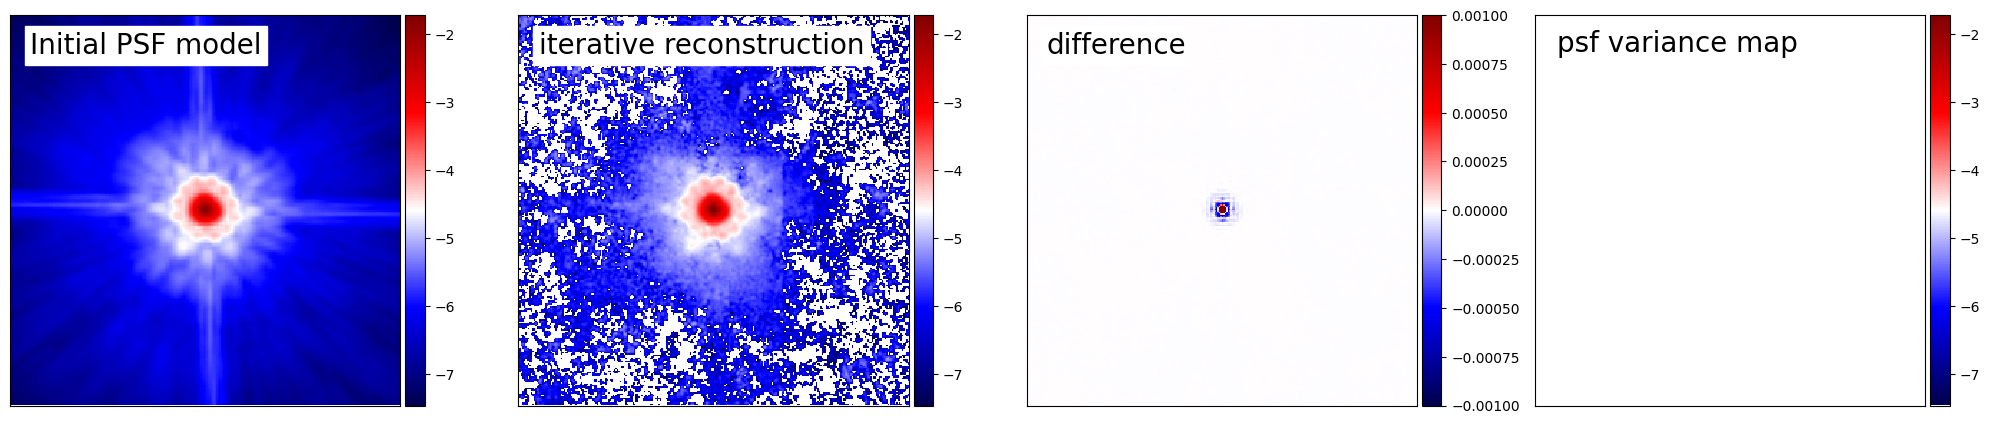

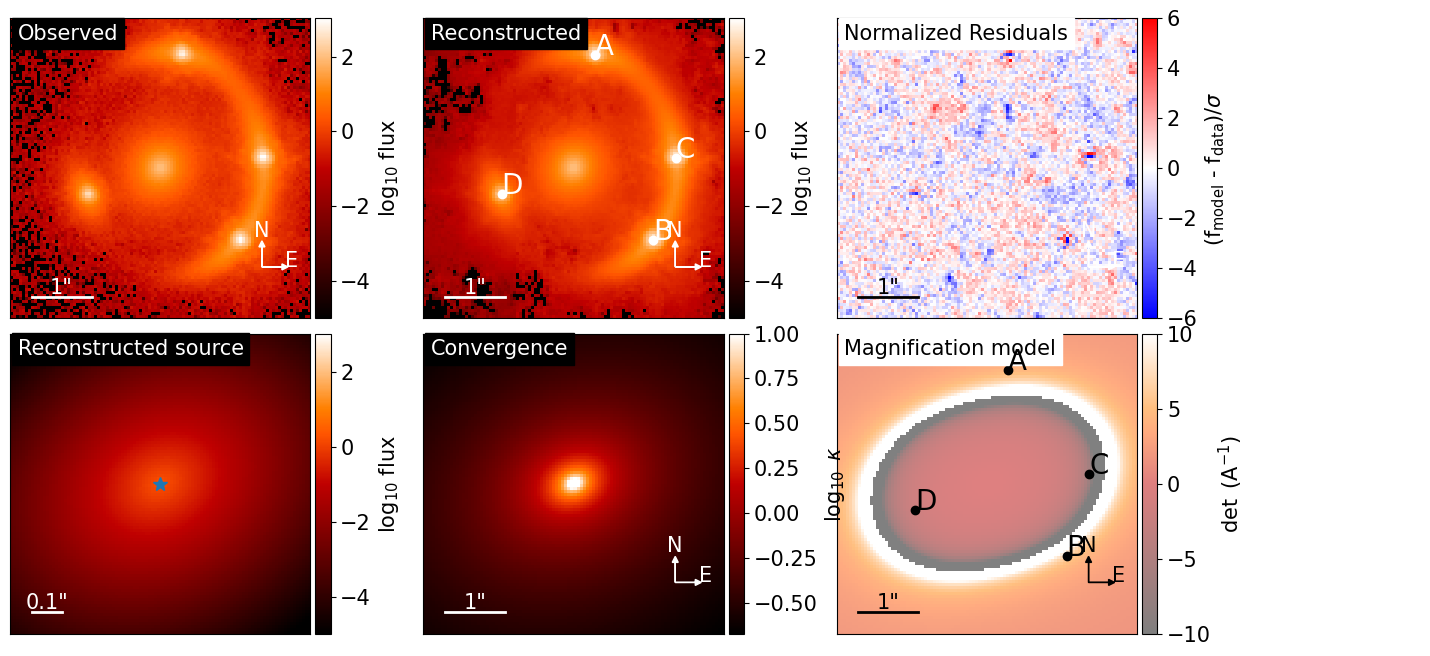

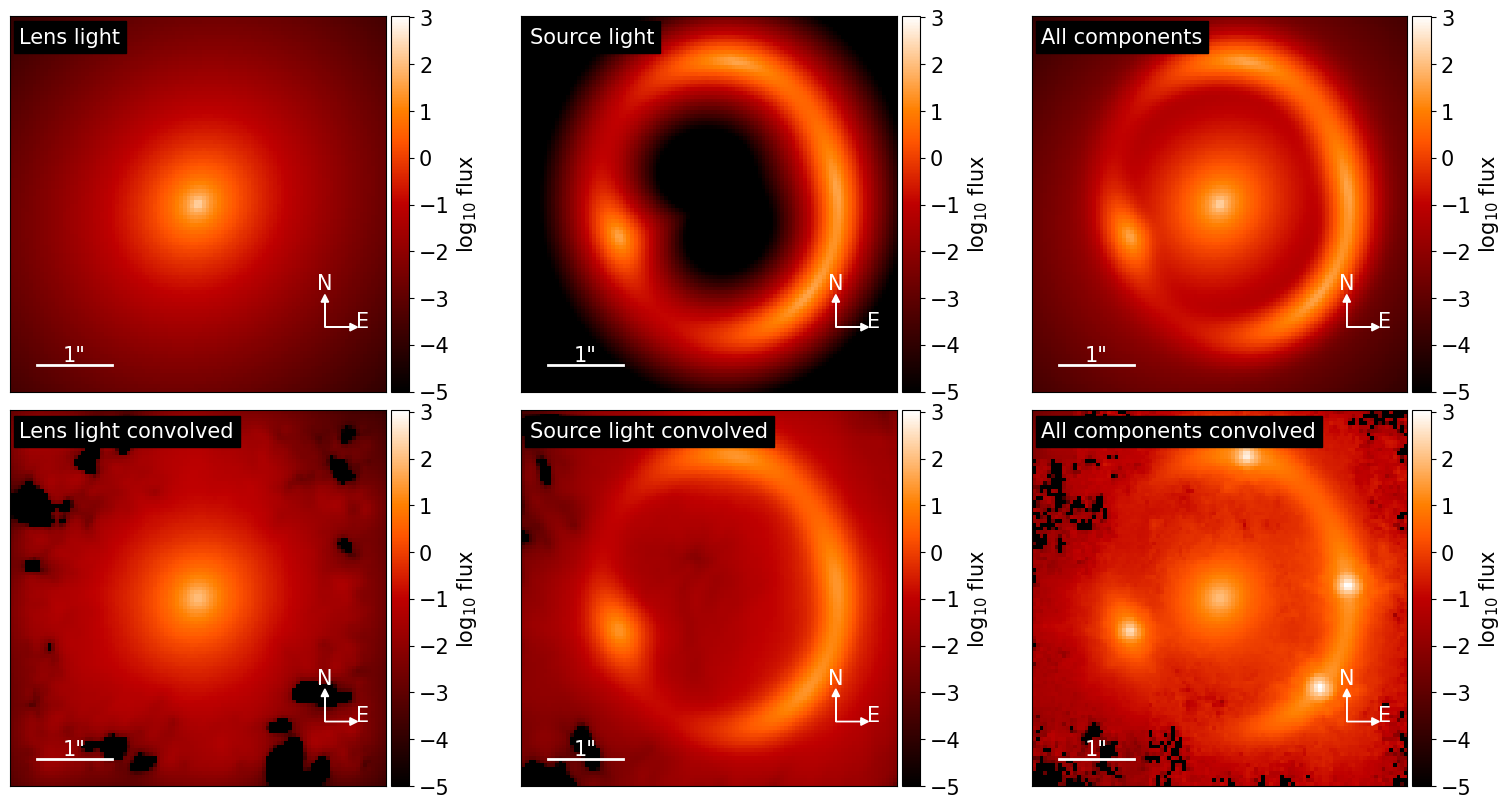

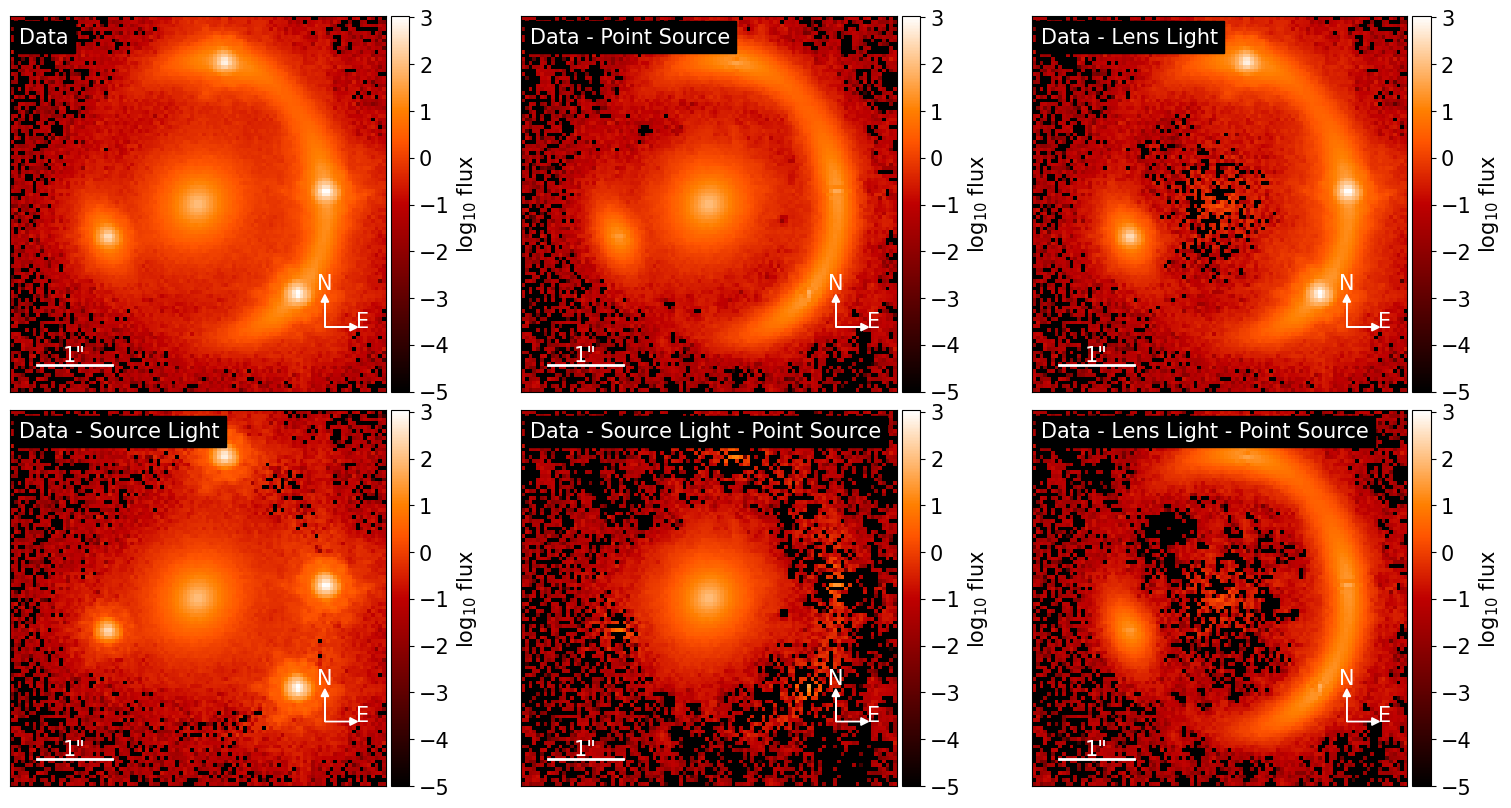

In [10]:
# and now we run another PSO optimization followed by another PSF iteration
fitting_kwargs_list = [['update_settings', {'lens_remove_fixed': [[0, ['gamma']]]}],
    ['PSO', {'sigma_scale': sigma_scale, 'n_particles': 100, 'n_iterations': 100}],
    ['psf_iteration', kwargs_psf_iter],
    ['PSO', {'sigma_scale': sigma_scale, 'n_particles': 100, 'n_iterations': 100}],
    ['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

multi_band_list = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]
f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()

Computing the PSO ...


100%|████████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


Max iteration reached! Stopping.
-1.2899958435829744 reduced X^2 of best position
-6432.564274026501 log likelihood
9973 effective number of data points
[{'theta_E': np.float64(1.655113527533544), 'gamma': np.float64(1.9958908656654857), 'e1': np.float64(0.08716672825253458), 'e2': np.float64(0.09391683490631743), 'center_x': np.float64(0.01088064428285481), 'center_y': np.float64(0.004965234500145568)}, {'gamma1': np.float64(-0.061133482686683865), 'gamma2': np.float64(-0.0065434520867257324), 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': np.float64(0.10231526863092008), 'n_sersic': np.float64(0.9724059395568796), 'e1': np.float64(0.07438094886995454), 'e2': np.float64(0.09963821218540843), 'center_x': np.float64(0.2126751822446289), 'center_y': np.float64(0.10489099250069238)}] source result
[{'amp': 1, 'R_sersic': np.float64(0.20164976551553274), 'n_sersic': np.float64(2.0150236370644246), 'e1': np.float64(-0.015412961579344792), 'e2': np.float64(0.05764347735882137), 

100%|████████████████████████████████████████████████████████████| 100/100 [05:23<00:00,  3.24s/it]
/tmp/ipykernel_218841/4013513248.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


Computing the MCMC...
Number of walkers =  220
Burn-in iterations:  50
Sampling iterations (in current run): 100
327.16002082824707 time taken for MCMC sampling
-1.2873603569993348 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.2873603569993348


/tmp/ipykernel_218841/4013513248.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/tmp/ipykernel_218841/4013513248.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/tmp/ipykernel_218841/4013513248.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


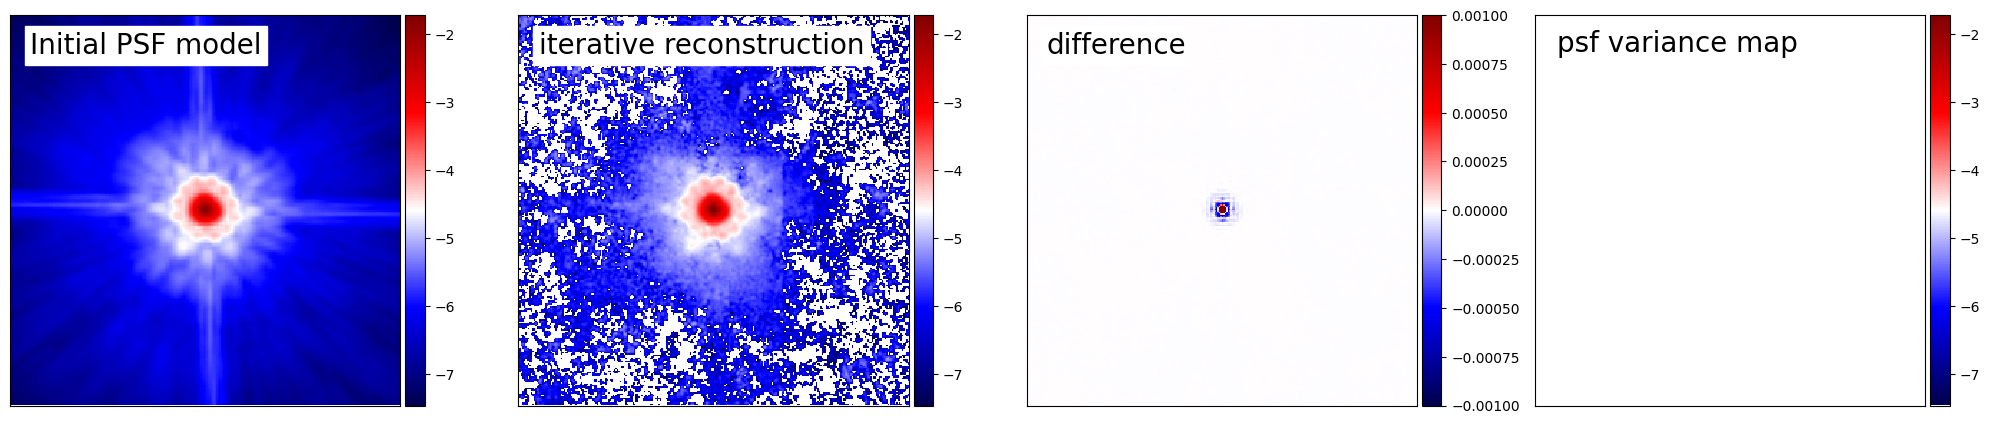

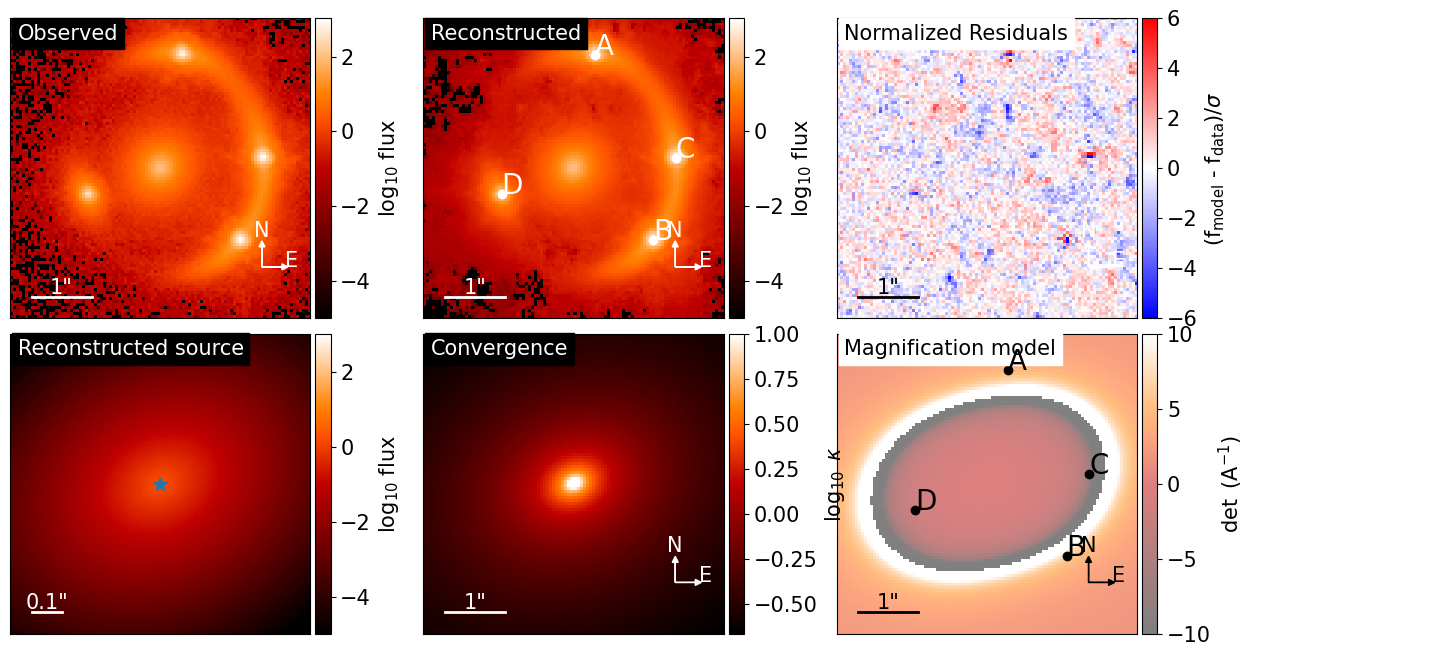

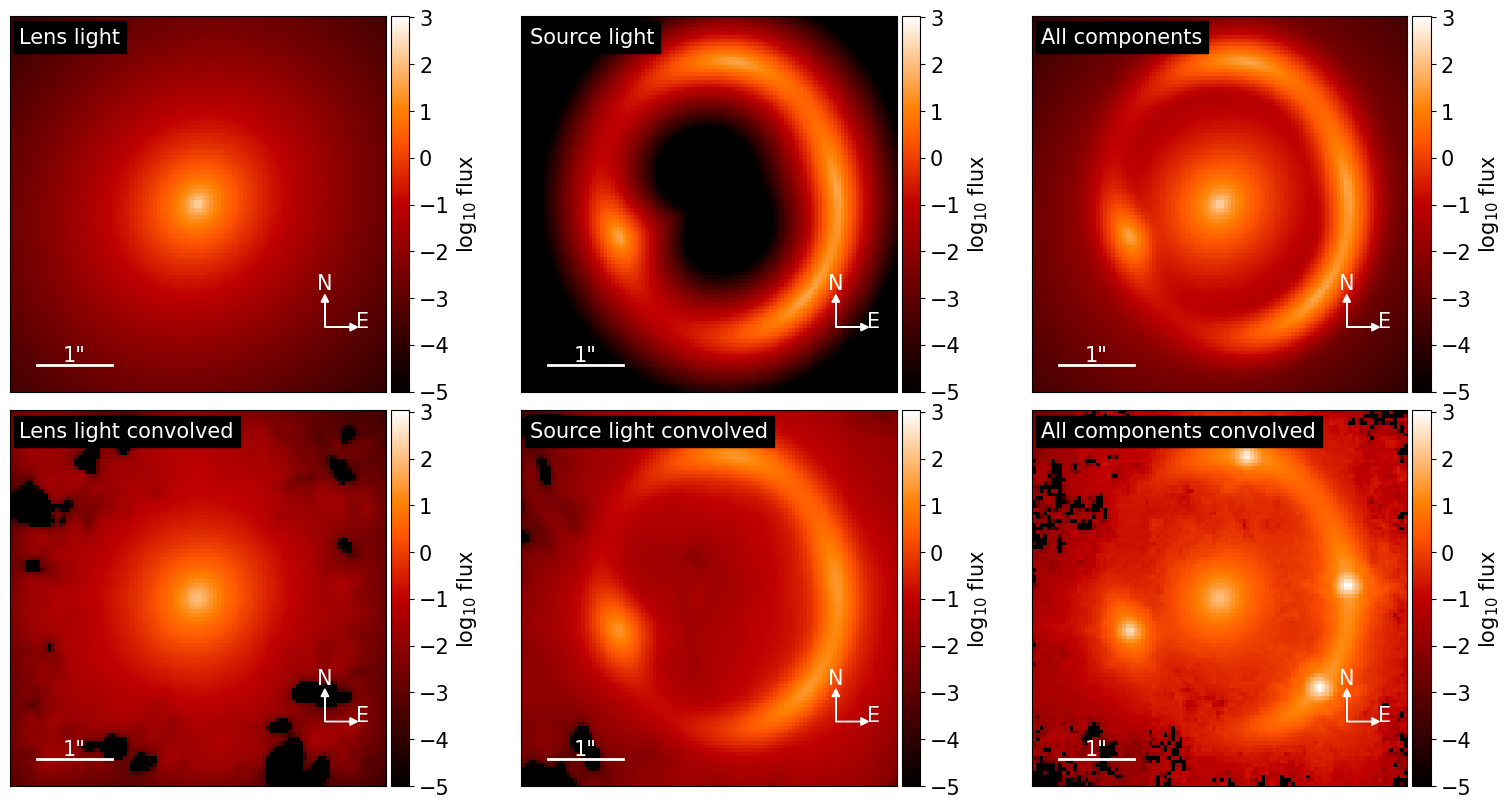

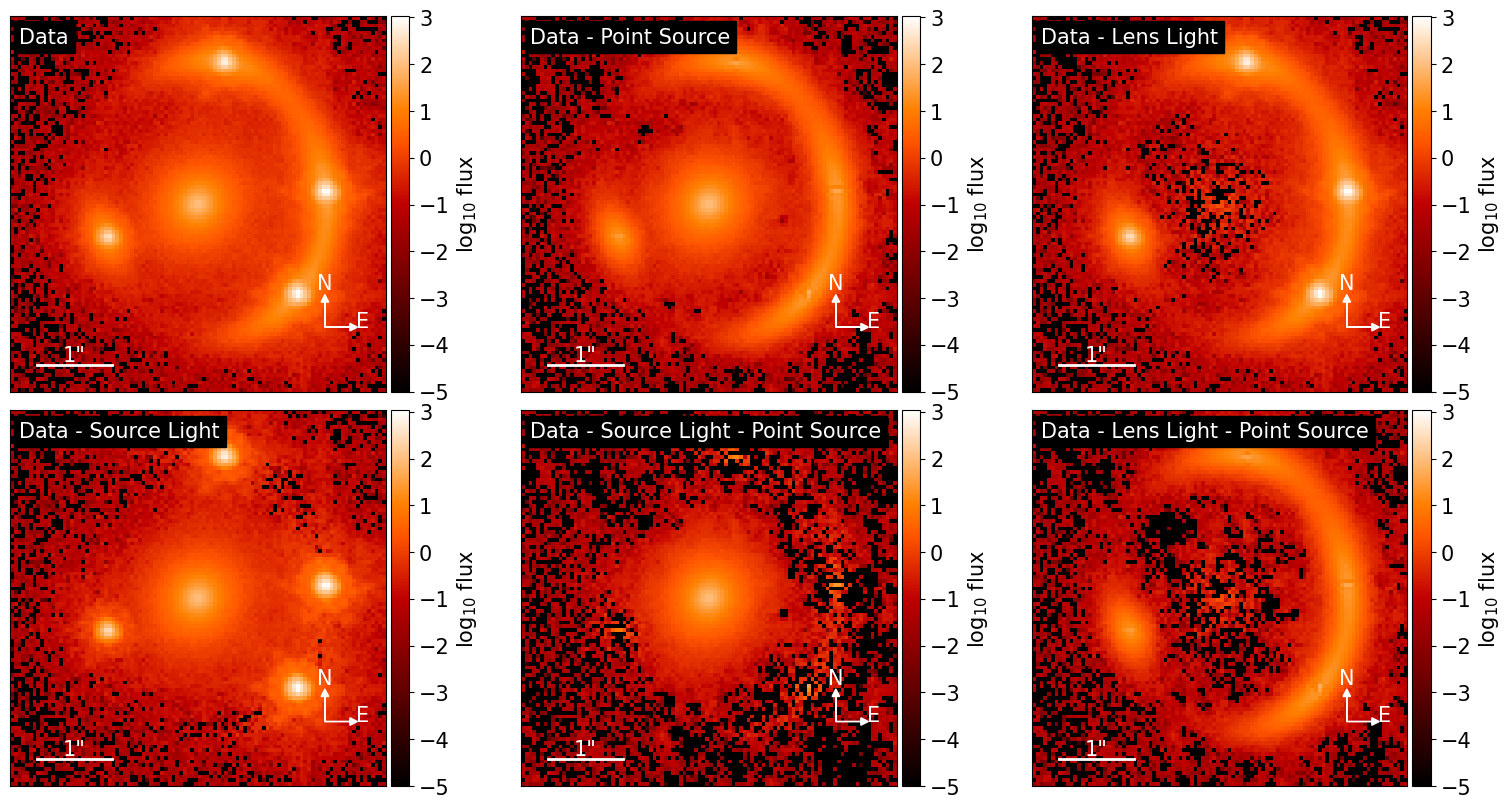

In [11]:
#and now we run the MCMC
fitting_kwargs_list = [
    ['PSO', {'sigma_scale': .1, 'n_particles': 100, 'n_iterations': 100}],
    ['MCMC', {'n_burn': 50, 'n_run': 50, 'walkerRatio': 10,'sigma_scale': .1}]
]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

multi_band_list = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]
f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()

number of non-linear parameters in the MCMC process:  22
parameters in order:  ['gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  11000


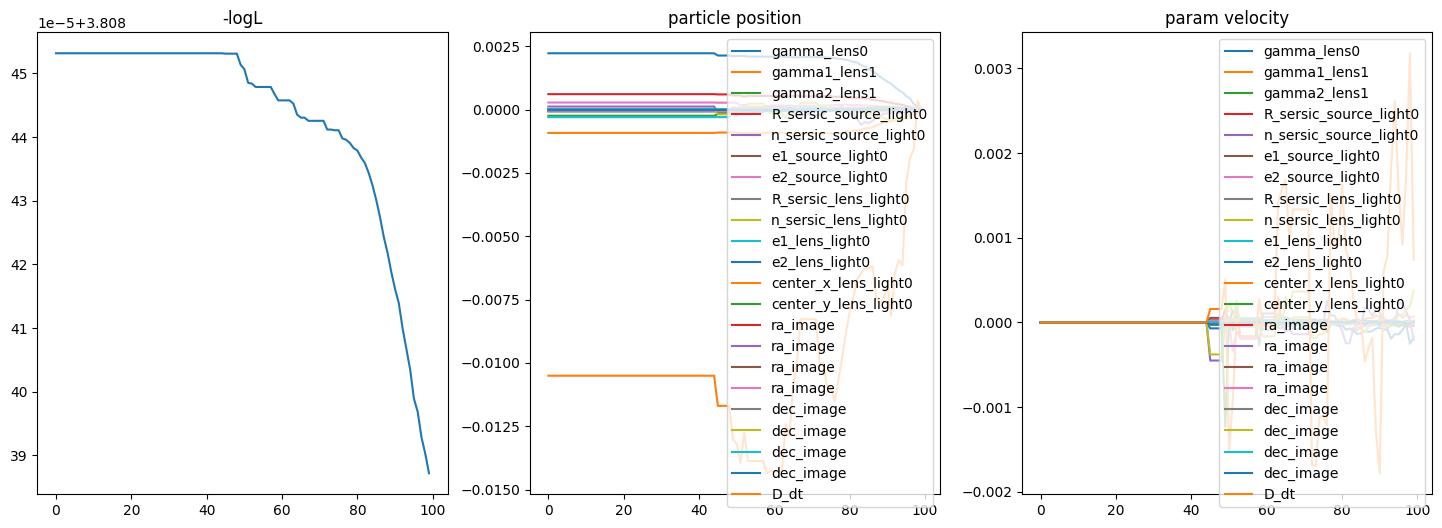

<Figure size 640x480 with 0 Axes>

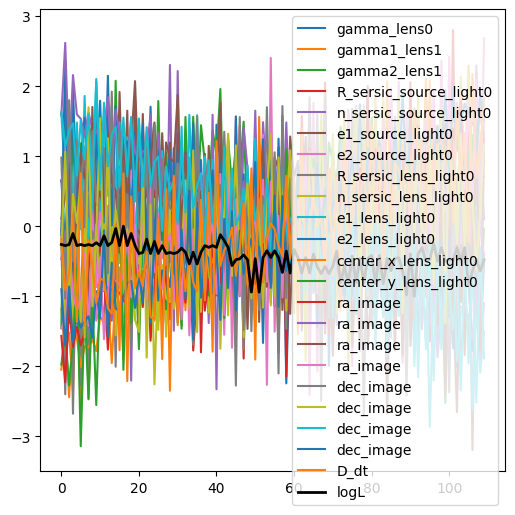

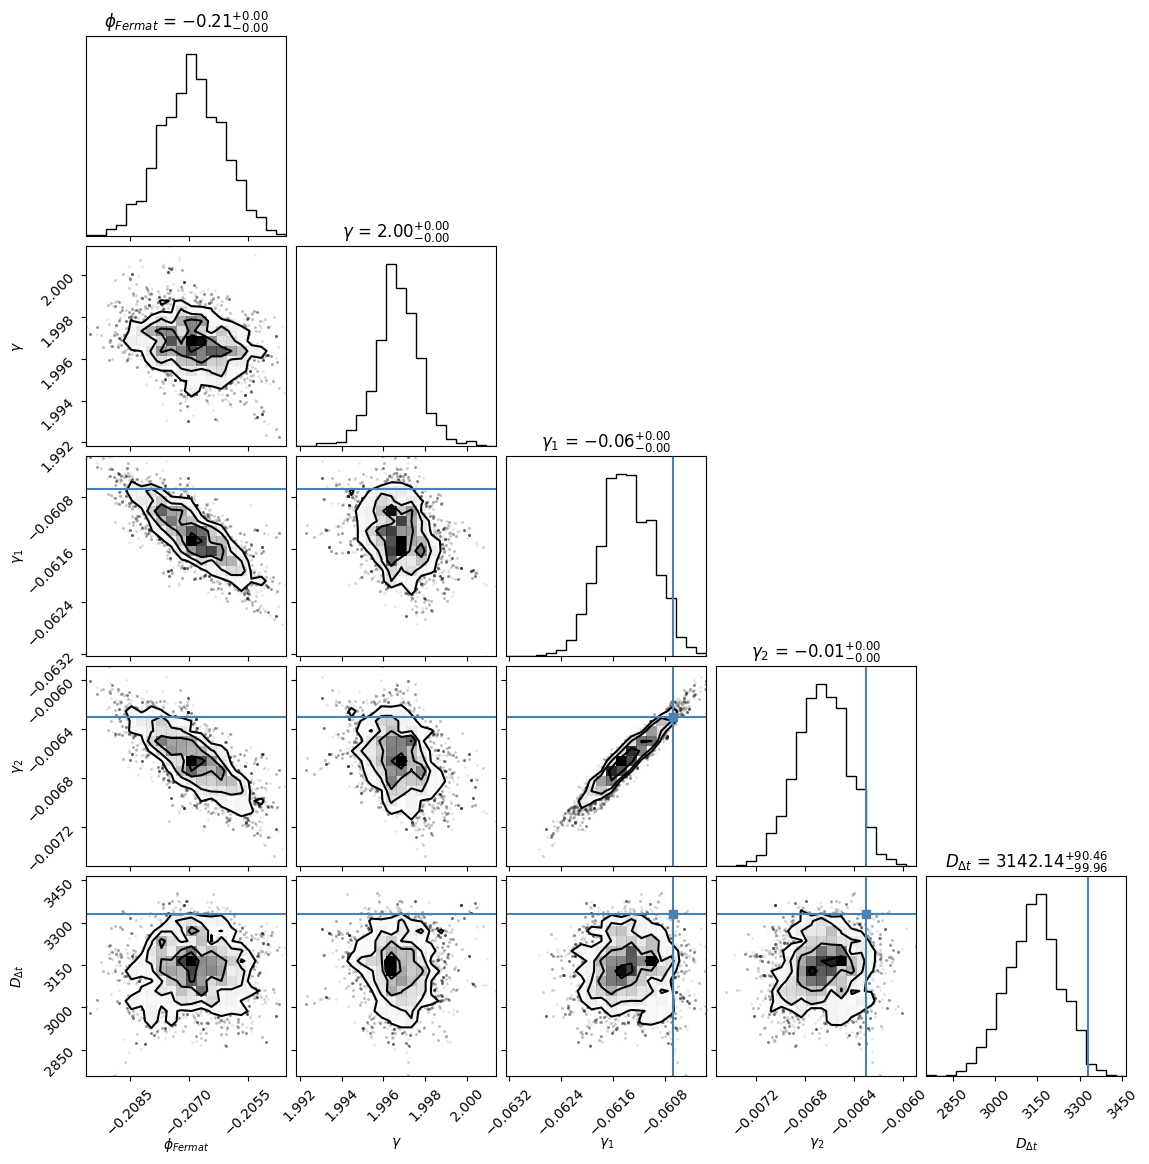

In [12]:
for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner


# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, fixed_lens, fixed_source, fixed_lens_light, fixed_ps, fixed_cosmo, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

from lenstronomy.Analysis.td_cosmography import TDCosmography
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

mcmc_new_list = []
labels_new = [r"$\phi_{Fermat}$", r"$\gamma$", r"$\gamma_1$", r"$\gamma_2$", r"$D_{\Delta t}$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    D_dt = kwargs_result['kwargs_special']['D_dt']
    fermat_pot = td_cosmo.fermat_potential(kwargs_result['kwargs_lens'], kwargs_result['kwargs_ps'])
    delta_fermat_12 = fermat_pot[0] - fermat_pot[2]
    gamma = kwargs_result['kwargs_lens'][0]['gamma']
    gamma1, gamma2, = kwargs_result['kwargs_lens'][1]['gamma1'], kwargs_result['kwargs_lens'][1]['gamma2']
    mcmc_new_list.append([delta_fermat_12, gamma, gamma1, gamma2, D_dt])

from lenstronomy.Cosmo.lens_cosmo import LensCosmo
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
Ddt_true = lensCosmo.ddt
truths=[np.nan, 1.95, gamma1, gamma2, Ddt_true]
plot = corner.corner(np.array(mcmc_new_list), labels=labels_new, show_titles=True, truths=truths)

In [13]:
print(lensCosmo.ddt)

3329.6653609254795
